In [1]:
# Cat meow classification 
# Author: Colin Pierce
# Computational Physics course at York University
# last updated 04 Aug 2022
#
#
#
#    Zzzzz  |\      _,,,--,,_        +-----------------------------+
#           /,`.-'`'   ._  \-;;,_    | Why is there always a cat   |
#          |,4-  ) )_   .;.(  `'-'   | on whatever you're editing?|
#         '---''(_/._)-'(_\_)        +-----------------------------+
#
# Art by Patrick Roberts

In [2]:
# import seaborn as sns
import matplotlib.pyplot as plt
# import plotly 
import math

import pandas as pd
import numpy as np
import os
# import playsound as playsound
import ipywidgets as widgets
from ipywidgets import *
import random 
from IPython.display import Audio

from scipy.io.wavfile import read
from scipy import signal
# import plotly.graph_objs as go
# from plotly.offline import plot, iplot

from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
# dataset = https://zenodo.org/record/4008297; https://link.springer.com/chapter/10.1007/978-3-030-67835-7_20
# consists of 4 kHz meows when the cat was being brushed, in isolation in an unfamiliar environment, or waiting for food 

# USER: this worksheet saves to ".../[root]/dataset/..."

C:\Users\Colin\AppData\Local\Temp\ipykernel_13924\868309507.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = read(".\dataset\%s"%i)


'Brushing' samples: 127, 'Food' samples: 92, 'Isolation' samples: 221

Mean, Median sample length = 1.830000 sec, 1.809562 sec
Range, Variance, Standard Deviation = 2.916000, 0.130205, 0.360840


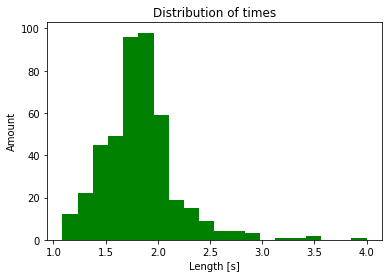

In [4]:
# begin with EDA on audio file data to motivate the appropriate transformations (warning is just for metadata)

dic = {}
names = []
totals = [0,0,0]
times = []

root, dirs, files = next(os.walk(".\dataset"))
for i in files:
    sit = i[0] # situation of meow (B, F, I = Brushing, Food, Isolation)
    rate, data = read(".\dataset\%s"%i)
    length = len(data)/rate
    dic[i]=[rate, data, length, sit] 
    names.append(i)
    times.append(length)
    
    if sit == "B":
        totals[0]+=1
    elif sit == "F":
        totals[1]+=1
    else:
        totals[2]+=1
        
plt.hist(times, bins=20, color="green")
# plt.grid()
plt.xlabel("Length [s]")
plt.ylabel("Amount")
plt.title("Distribution of times")

stats_d = [max(times)-min(times), np.var(times), np.std(times)] # measures of dispersion

print("'Brushing' samples: %d, 'Food' samples: %d, 'Isolation' samples: %d\n"%(totals[0],totals[1],totals[2]))
print("Mean, Median sample length = %f sec, %f sec"%(round(np.average(times),2),np.median(times)))
print("Range, Variance, Standard Deviation = %f, %f, %f"%(stats_d[0],stats_d[1],stats_d[2]))
    

In [5]:
# Play random cat meow from database

rand_choice = names[random.randint(0,len(names))]
print("Sample meow: '%s'"%rand_choice)
Audio(filename = ".\dataset\%s"%rand_choice)

Sample meow: 'I_CLE01_EU_FN_FER01_115.wav'


In [6]:
# Waveform plot for meows

def show_wave(db_index):
    name = names[db_index]
    # print("Meow choice: '%s'"%name )
    time = np.arange(0,dic[name][2],1/dic[name][0]) 
    data = dic[name][1]
    
    plt.plot(time,data)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("file: '%s'"%name)

interact(show_wave, db_index=widgets.IntSlider(value=0, min=0, max=len(names)-1, step=1))

interactive(children=(IntSlider(value=0, description='db_index', max=439), Output()), _dom_classes=('widget-in…

<function __main__.show_wave(db_index)>

In [7]:
# Spectrogram plot for meows

def show_spec(db_index):
    name = names[db_index]
    frequencies, times, spectrogram = signal.spectrogram(dic[name][1], dic[name][0])
    
    plt.pcolormesh(times, frequencies, spectrogram)#, cmap='Greys')
    # plt.imshow(spectrogram)
    # plt.colorbar()
    plt.ylabel('Frequency')
    plt.xlabel('Time')
    plt.title("file: '%s'"%name)

interact(show_spec, db_index=widgets.IntSlider(value=0, min=0, max=len(names)-1, step=1))

# Notice the harmonics in the meows (Eg, meow number 39, 81, 94 or 174)
# (This exists in the human voice as well and is what we will try to learn)

# Can click on db_index number to type meow index

interactive(children=(IntSlider(value=0, description='db_index', max=439), Output()), _dom_classes=('widget-in…

<function __main__.show_spec(db_index)>

In [8]:
# The data needs to be simplified. 
# The most audible harmonic is the loudest one. We will standardize the data by selecting the loudest power output per meow.
# We will approximate meow length by finding the range of the closest points within a close enough power range (80% of max)

In [9]:
# Find all neighboring points appropriately close to the max power output of the spectrogram

def find_neighbors(m, i, j): # grid-crawling helper function
    d1 = [(i+1, j), (i+1, j), (i+1,j-1), (i,j+1), (i,j-1), (i-1, j+1), (i-1, j+1), (i-1, j-1)]
    d2a = [(i+2, j), (i+2, j+1), (i+2, j+2), (i+2, j-1), (i+2, j-2), (i+1, j-2), (i+1, j+2), (i, j+2), (i, j-2)]
    d2b = [(i-1, j+2), (i-1, j-2), (i-2,j+2), (i-2,j+1), (i-2,j), (i-2,j-1), (i-2,j-2)]
    return d1 + d2a + d2b

dic2 = {} 
index=1
for j in names:
    sit = j[0] # meow class
    
    pts = [] # distributions
    pts_t = []
    powers = []
    ts = []
    frequencies, times, spectrogram = signal.spectrogram(dic[j][1], dic[j][0]) 
    
    #ind = np.unravel_index(np.argmax(spectrogram, axis=None), spectrogram.shape) 
    ind = np.where(spectrogram == spectrogram.max()) # find loudest frequency index
    ind = (ind[0][0], ind[1][0])
    
    lf = frequencies[ind[0]] # find time, frequency points
    lf_time = times[ind[1]]
    
    power = spectrogram[ind[0]][ind[1]] # find its loudness
    
    init_power = power
    neighbors = find_neighbors(spectrogram, ind[0], ind[1]) # find loudest point neighbors
    
    conv = 0 # convergence criteria
    while abs(power-init_power)<(0.8*init_power): # power criteria
        if conv>10: 
            break
        pts.append(ind) 
        pts_t.append((lf_time, lf))
        powers.append(power)
        ts.append(lf_time)
        
        neighbors = find_neighbors(spectrogram, ind[0], ind[1]) # find neighbors
        
        for pie in neighbors: # prevent backwards crawl
            if pie in pts:
                indd = neighbors.index(pie)
                del neighbors[indd]
        
        sub_powers = [] # find loudest of neighbors
        for foo in neighbors:
            sub_power = spectrogram[foo[0]][foo[1]]
            sub_powers.append(sub_power)
        
        power = max(sub_powers) # find loudest
        ind = neighbors[sub_powers.index(power)] # find loudest index
        lf = frequencies[ind[0]] # find time, frequency points
        lf_time = times[ind[1]]
        
        conv+=1    
        
    print("Completed: %d/%d    "%(index,len(names)), end="\r")
    index+=1
    
    rnge = max(ts)-min(ts)
    dic2[j]=[lf, rnge, pts, pts_t, powers, sit] 
    # key: loudest freq, range(times), pts, pts (time,freq), lf's of pts,  class

df = pd.DataFrame(dic2)
df.to_pickle("data_transform.pkl")

In [10]:
# Observe our extracted data superimposed on the spectrograms

df = pd.read_pickle("data_transform.pkl")

def show_spec_mod(db_index):
    name = names[db_index]
    frequencies, times, spectrogram = signal.spectrogram(dic[name][1], dic[name][0])
    
    ptss = df[name][2]
    xs = []
    ys = []
    
    for j in ptss:
        ys.append(frequencies[j[0]])
        xs.append(times[j[1]])
        
    coords = [(xs[i], ys[i]) for i in range(len(xs))]
    print("Points: ", end='')
    print(coords)
    
    plt.pcolormesh(times, frequencies, spectrogram)#, cmap='Greys')
    plt.scatter(xs, ys, color="red")
    plt.ylabel('Frequency')
    plt.xlabel('Time')
    plt.title("file: '%s'"%name)
    
interact(show_spec_mod, db_index=widgets.IntSlider(value=0, min=0, max=len(names)-1, step=1))

interactive(children=(IntSlider(value=0, description='db_index', max=439), Output()), _dom_classes=('widget-in…

<function __main__.show_spec_mod(db_index)>

In [11]:
df

,B_ANI01_MC_FN_SIM01_101.wav,B_ANI01_MC_FN_SIM01_102.wav,B_ANI01_MC_FN_SIM01_103.wav,B_ANI01_MC_FN_SIM01_301.wav,B_ANI01_MC_FN_SIM01_302.wav,B_ANI01_MC_FN_SIM01_303.wav,B_BAC01_MC_MN_SIM01_101.wav,B_BAC01_MC_MN_SIM01_102.wav,B_BAC01_MC_MN_SIM01_103.wav,B_BAC01_MC_MN_SIM01_202.wav,...,I_WHO01_MC_FI_SIM01_109.wav,I_WHO01_MC_FI_SIM01_110.wav,I_WHO01_MC_FI_SIM01_111.wav,I_WHO01_MC_FI_SIM01_112.wav,I_WHO01_MC_FI_SIM01_113.wav,I_WHO01_MC_FI_SIM01_114.wav,I_WHO01_MC_FI_SIM01_115.wav,I_WHO01_MC_FI_SIM01_116.wav,I_WHO01_MC_FI_SIM01_201.wav,I_WHO01_MC_FI_SIM01_301.wav
0,2062.5,1906.25,781.25,2187.5,1281.25,781.25,1531.25,750.0,1156.25,1781.25,...,1593.75,1468.75,1625.0,1375.0,1437.5,1781.25,1500.0,843.75,875.0,937.5
1,0.056,0.0,0.112,0.0,0.028,0.112,0.028,0.056,0.0,0.028,...,0.028,0.084,0.112,0.28,0.14,0.056,0.084,0.252,0.112,0.112
2,"[(67, 27), (65, 26), (67, 25)]","[(62, 25), (63, 25)]","[(25, 42), (25, 41), (25, 43), (24, 44), (24, ...","[(71, 30), (72, 30)]","[(40, 24), (39, 25), (40, 25), (41, 25)]","[(24, 23), (24, 25), (24, 27), (24, 26), (24, ...","[(50, 19), (48, 18), (49, 18), (49, 19), (50, ...","[(23, 21), (22, 20), (22, 21), (23, 21), (23, ...","[(37, 18)]","[(57, 20), (58, 20), (59, 20), (57, 21), (58, ...",...,"[(54, 19), (52, 18), (52, 19), (53, 19), (54, ...","[(46, 30), (47, 28), (46, 29), (46, 30), (47, ...","[(53, 27), (53, 28), (52, 29), (52, 31), (52, ...","[(42, 35), (43, 33), (45, 31), (44, 30), (45, ...","[(46, 37), (45, 36), (44, 34), (46, 32), (45, ...","[(56, 19), (58, 20), (56, 18)]","[(47, 20), (49, 21), (48, 20), (50, 22), (50, ...","[(31, 29), (31, 30), (31, 28), (30, 27), (29, ...","[(29, 45), (29, 44), (28, 46), (28, 48), (28, ...","[(30, 19), (30, 20), (30, 21), (31, 21), (31, ..."
3,"[(0.772, 2093.75), (0.744, 2031.25), (0.716, 2...","[(0.716, 1937.5), (0.716, 1968.75)]","[(1.192, 781.25), (1.164, 781.25), (1.22, 781....","[(0.856, 2218.75), (0.856, 2250.0)]","[(0.688, 1250.0), (0.716, 1218.75), (0.716, 12...","[(0.66, 750.0), (0.716, 750.0), (0.772, 750.0)...","[(0.548, 1562.5), (0.52, 1500.0), (0.52, 1531....","[(0.604, 718.75), (0.576, 687.5), (0.604, 687....","[(0.52, 1156.25)]","[(0.576, 1781.25), (0.576, 1812.5), (0.576, 18...",...,"[(0.548, 1687.5), (0.52, 1625.0), (0.548, 1625...","[(0.856, 1437.5), (0.8, 1468.75), (0.828, 1437...","[(0.772, 1656.25), (0.8, 1656.25), (0.828, 162...","[(0.996, 1312.5), (0.94, 1343.75), (0.884, 140...","[(1.052, 1437.5), (1.024, 1406.25), (0.968, 13...","[(0.548, 1750.0), (0.576, 1812.5), (0.52, 1750...","[(0.576, 1468.75), (0.604, 1531.25), (0.576, 1...","[(0.828, 968.75), (0.856, 968.75), (0.8, 968.7...","[(1.276, 906.25), (1.248, 906.25), (1.304, 875...","[(0.548, 937.5), (0.576, 937.5), (0.604, 937.5..."
4,"[814917.25, 517826.1, 221337.53]","[24684.695, 11031.599]","[23927.254, 23664.678, 11953.76, 9442.379, 630...","[190331.83, 105460.625]","[34500.895, 31880.227, 25889.887, 8728.585]","[180125.53, 171388.73, 143750.44, 139160.5, 17...","[379110.22, 309559.56, 90019.04, 91035.46, 379...","[206189.02, 198808.81, 111846.695, 206189.02, ...",[380513.78],"[120170.664, 94456.23, 73369.66, 56695.97, 430...",...,"[356682.75, 235542.02, 187943.08, 279039.16, 3...","[1461928.1, 1178366.9, 1153681.1, 1461928.1, 6...","[876661.2, 632930.56, 574416.0, 420703.4, 3969...","[1789193.8, 1306984.2, 1407700.6, 1502644.2, 1...","[323468.62, 283697.1, 273400.25, 186278.25, 16...","[948835.56, 421314.84, 382059.16]","[898126.7, 663147.56, 451080.22, 755902.5, 259...","[306916.16, 267792.88, 241523.19, 143637.55, 1...","[361926.94, 248075.06, 204349.86, 250089.6, 21...","[599103.2, 386258.16, 325861.2, 184409.73, 237..."
5,B,B,B,B,B,B,B,B,B,B,...,I,I,I,I,I,I,I,I,I,I


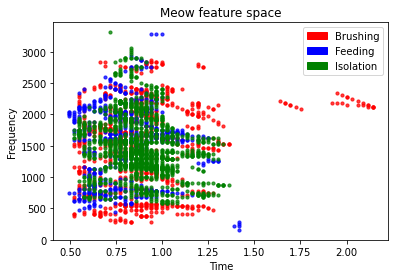

In [12]:
# Plot meow features space

import matplotlib.patches as mpatches

labels = []
for r in df:
    xs = []
    ys = []
    
    frequencies, times, spectrogram = signal.spectrogram(dic[r][1], dic[r][0])
    
    pts = df[r][2]
    for i in pts:
        ys.append(frequencies[i[0]])
        xs.append(times[i[1]])
        
    sit = df[r][5]
    labels.append(sit)
    colors = {"B":"red", "F":"blue", "I":"green"} 

    #if len(set(xs))==len(xs):
    plt.scatter(xs, ys, s=10, c=colors[sit], label = str(sit), alpha=0.75)
        
red = mpatches.Patch(color='red', label='Brushing')
blue = mpatches.Patch(color='blue', label='Feeding')
green = mpatches.Patch(color='green', label='Isolation')

plt.title("Meow feature space")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.legend(handles=[red, blue, green], loc='upper right')

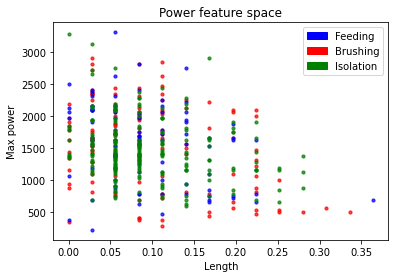

In [13]:
# Plot loudest frequency and approx meow length

labels = []
for r in df:
    xs = []
    ys = []
    xs.append(df[r][1])
    ys.append(df[r][0])
    
    sit = df[r][5]
    labels.append(sit)
    colors = {"B":"red", "F":"blue", "I":"green"} 

    #if len(set(xs))==len(xs):
    plt.scatter(xs, ys, s=10, c=colors[sit], label = str(sit), alpha=0.75)
    
red = mpatches.Patch(color='red', label='Brushing')
blue = mpatches.Patch(color='blue', label='Feeding')
green = mpatches.Patch(color='green', label='Isolation')

plt.title("Power feature space")
plt.xlabel("Length")
plt.ylabel("Max power")
plt.legend(handles=[blue, red, green], loc='upper right')

In [14]:
# Transpose dataframe for KNN

pwrs = []
lens = []
clss = []

key = {"B":0, "F":1, "I":2}
for j in df:
    pwrs.append(df[j][0])
    lens.append(df[j][1])
    clss.append(key[df[j][5]])

df2 = {"power":pwrs, "lengths": lens, "class":clss}
df2 = pd.DataFrame(df2)
df2.shape
df2

,power,lengths,class
0,2062.50,0.056,0
1,1906.25,0.000,0
2,781.25,0.112,0
3,2187.50,0.000,0
4,1281.25,0.028,0
...,...,...,...
435,1781.25,0.056,2
436,1500.00,0.084,2
437,843.75,0.252,2
438,875.00,0.112,2


In [15]:
# Build KNN classifier

X_data = df2.drop(['class'],axis=1)
data = pd.DataFrame(X_data,columns=['power', 'length'])
y_data = df2['class']

X_train, X_test, y_train, y_test = train_test_split(df2, y_data,test_size=0.2, random_state = 1)

knn = KNeighborsClassifier()

knn.fit(X_train,y_train)

ypred=knn.predict(X_test)

# Test model

res= confusion_matrix(y_test, ypred)
print('Confusion matrix:')
print(res)
print("\n")

res2 = classification_report(y_test, ypred)
print('Classification report:')
print(res2)

res3 = accuracy_score(y_test,ypred)
print("Accuracy:", res3)

Confusion matrix:
[[16  1  2]
 [ 5  6  7]
 [ 4  9 38]]


Classification report:
              precision    recall  f1-score   support

           0       0.64      0.84      0.73        19
           1       0.38      0.33      0.35        18
           2       0.81      0.75      0.78        51

    accuracy                           0.68        88
   macro avg       0.61      0.64      0.62        88
weighted avg       0.68      0.68      0.68        88

Accuracy: 0.6818181818181818


In [16]:
# Redo with different train/test split

X_data = df2.drop(['class'],axis=1)
data = pd.DataFrame(X_data,columns=['power', 'length'])
y_data = df2['class']

X_train, X_test, y_train, y_test = train_test_split(df2, y_data,test_size=0.3, random_state = 3)

knn = KNeighborsClassifier()

knn.fit(X_train,y_train)

ypred=knn.predict(X_test)

# Test model

res= confusion_matrix(y_test, ypred)
print('Confusion matrix:')
print(res)
print("\n")

res2 = classification_report(y_test, ypred)
print('Classification report:')
print(res2)

res3 = accuracy_score(y_test,ypred)
print("Accuracy:", res3)

Confusion matrix:
[[29  4  6]
 [10 10 11]
 [ 5  4 53]]


Classification report:
              precision    recall  f1-score   support

           0       0.66      0.74      0.70        39
           1       0.56      0.32      0.41        31
           2       0.76      0.85      0.80        62

    accuracy                           0.70       132
   macro avg       0.66      0.64      0.64       132
weighted avg       0.68      0.70      0.68       132

Accuracy: 0.696969696969697
